In [113]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [114]:
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
data1 = data.set_index(['Genotype','Behavior','Treatment','class','Mouse'])

In [115]:
yticks = [0,10,19,29,38,47,54,63]
yticklabels = ['Control Learning Treated',
               'Control Learning Untreated',
               'Control NoLearning Treated',
               'Control NoLearning Untreated',
               'Downs Learning Treated',
               'Downs Learning Untreated',
               'Downs NoLearning Treated',
               'Downs NoLearning Untreated']

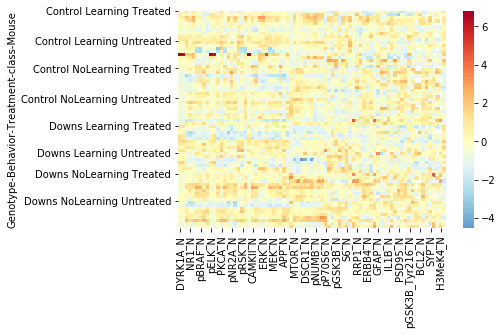

In [116]:
#Heatmap of normalized data
ax = sns.heatmap((data1-data1.mean())/data1.std(),yticklabels=yticklabels,center=0,cmap='RdYlBu_r')
ax.set_yticks(yticks)
ax

In [161]:
# Apparently I can't use clustermap with missing values and I can't colorcode groups with a multiindex
# First, ignore proteins with missing values
data2 = data.loc[:,data.isnull().sum()==0]
# Then remove all non-protein variables, saving class for color-coding
groups = data2.pop('class')
data2 = data2.drop(['Genotype','Behavior','Treatment','Mouse'],axis=1)
# Create color code for row clustering
row_colors = groups.map(dict(zip(groups.unique(), "rygcbmkw")))

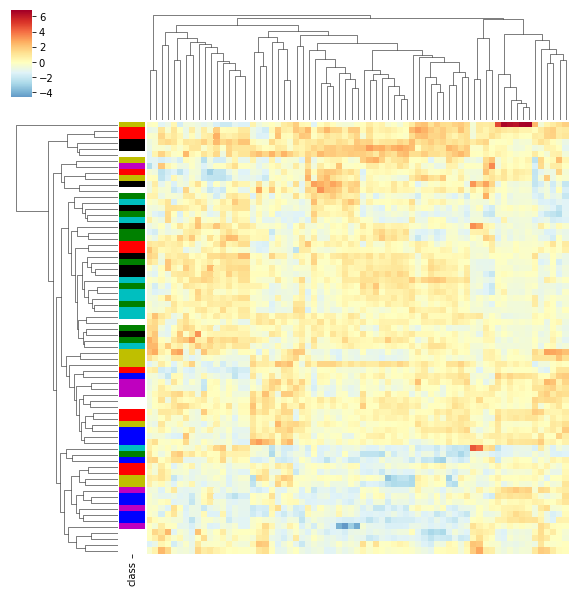

In [163]:
ax3=sns.clustermap(data2,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=False,yticklabels=False)

In [147]:
data3.head(15)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N
Mouse,,,,,,,,,,,,,,,,,,,,,
309,0.421063,0.576510,0.356447,2.278252,4.354744,0.219549,0.182195,1.922373,0.196064,1.422933,...,0.249827,1.420349,1.913860,0.122842,0.974790,0.832559,0.192871,0.101042,0.423088,1.674160
311,0.600591,0.678479,0.334548,2.277561,4.234706,0.227820,0.184262,1.931669,0.176511,1.874307,...,0.237131,1.070626,1.587826,0.151819,1.077758,0.673229,0.188092,0.105205,0.426774,1.193285
320,0.547676,0.796012,0.398649,2.664515,5.498960,0.241391,0.194097,2.406303,0.218364,1.815423,...,0.316497,1.546658,2.151820,0.164331,1.271488,0.859745,0.218300,0.133335,0.538909,1.624791
321,0.438728,0.652045,0.359441,2.686405,5.298355,0.231876,0.184874,2.502274,0.199109,1.535018,...,0.330512,1.633391,2.429311,0.174338,1.334534,0.922949,0.238123,0.136769,0.559531,1.678225
322,0.358931,0.512223,0.315105,2.111664,4.231444,0.232415,0.183995,3.574599,0.182309,1.245066,...,0.315504,1.756976,2.248522,0.172373,1.311125,0.828905,0.239495,0.139037,0.493076,1.607234
3415,0.497119,0.656343,0.314838,2.366336,4.139486,0.212674,0.165161,3.379866,0.179236,1.348521,...,0.309948,1.435369,2.141224,0.150927,1.073417,0.890580,0.226604,0.116150,0.400342,1.376609
3499,0.319708,0.485349,0.288157,2.176302,3.350919,0.194603,0.152684,3.088278,0.177566,1.080352,...,0.319998,1.443368,2.118927,0.142935,1.055164,0.863529,0.236888,0.106498,0.409312,1.436117
3507,0.373571,0.539847,0.317287,2.318377,3.992429,0.233426,0.184312,2.141755,0.215901,1.305367,...,0.297503,1.659137,2.346219,0.159796,1.205576,0.842719,0.235414,0.117751,0.494081,1.543584
3520,0.618710,0.803561,0.341402,2.522965,3.863553,0.261868,0.197174,3.505510,0.216023,1.649991,...,0.314405,1.806596,2.306967,0.147696,1.272519,1.006548,0.249159,0.123046,0.478482,1.582685
